In [2]:
# Make sure to install the following Python packages:
# numpy
# matplotlib
# ipympl

# for gps plots:
# ipyleaflet 
# also, make sure to install nodejs (https://pypi.org/project/nodejs/)
# also execute the following command: jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-leaflet

import matplotlib.pyplot as plt 

# You may make changes to the Lilygo module but your algorithm must work with the original version
# If you want to propose changes to the module, create a pull-request on github
from Lilygo.Recording import Recording, data_integrity
from Lilygo.Dataset import Dataset

#For interactive graphs
%matplotlib widget

# Reading sensor data from JSON file

Create an instance of the <code>Recording</code> class that manages the data from a file

In [3]:
trace = Recording('data/example/medium_walk.json', no_labels=True, mute=True) #second example file: data/example/short_walk.json

trace.DataIntegrityCheck()

#The data is stored inside a dictionary (access: trace.data["key"])
print("\r\nAvailable data traces:")
print(list(trace.data.keys()))

if not(trace.labels is None):
    print("\r\nLabels: ")
    print(trace.labels)

Loaded data from file that does not contain labels.
Please mute this message by setting mute=True in your algorithm submission
🟠 Warning: data trace phone_pressure missing
Finished Integrity Check!
🟠 Despite missing 1 non-essential sensors, this trace is suitable for submission as far as this automated test can judge.
🟠 However, the trace is missing the required labels for submission

Available data traces:
['phone_magrotx', 'phone_laz', 'phone_ax', 'phone_gz', 'az', 'speed', 'phone_mz', 'phone_orientationy', 'phone_roty', 'phone_lax', 'phone_orientationz', 'longitude', 'ax', 'phone_rotm', 'phone_magroty', 'phone_my', 'bearing', 'phone_gravx', 'phone_lay', 'phone_light', 'phone_ay', 'my', 'gz', 'mx', 'packetNumber', 'altitude', 'gx', 'temperature', 'ay', 'phone_mx', 'phone_gravy', 'phone_rotz', 'gy', 'timestamp', 'latitude', 'phone_az', 'mz', 'phone_gx', 'phone_orientationx', 'phone_magrotz', 'phone_gy', 'phone_rotx', 'phone_gravz']


## Working with timeseries
Every value in this dictionary holds a <code>Dataset</code> object to manage the data from one sensor

In [4]:
# X-axis of the LILYGO accelerometer
ax = trace.data['ax']

print(f"Name of sensor: '{ax.title}'")
print(f"Sample rate: {int(ax.samplerate)} Hz")
print(f"Recording length: {ax.total_time} seconds")
print(f"Timestamp of recording: {ax.raw_timestamps[0][1]}")
print("\nGetting a time series:")
print(" Time           x-Accel")
for x, t in list(zip(ax.timestamps, ax.values))[:20]:
    print(f"{x: .3f}s \t{t:.5f}g")

Name of sensor: 'ax'
Sample rate: 200 Hz
Recording length: 136.789 seconds
Timestamp of recording: 1645184293057

Getting a time series:
 Time           x-Accel
 0.000s 	-0.41138g
 0.005s 	-0.40381g
 0.010s 	-0.38452g
 0.015s 	-0.35645g
 0.020s 	-0.32031g
 0.025s 	-0.29248g
 0.030s 	-0.25635g
 0.035s 	-0.21118g
 0.040s 	-0.17676g
 0.045s 	-0.16138g
 0.050s 	-0.14624g
 0.055s 	-0.13989g
 0.060s 	-0.14624g
 0.065s 	-0.14209g
 0.070s 	-0.15576g
 0.075s 	-0.16821g
 0.080s 	-0.17773g
 0.085s 	-0.19019g
 0.090s 	-0.19946g
 0.095s 	-0.20752g


# Plotting

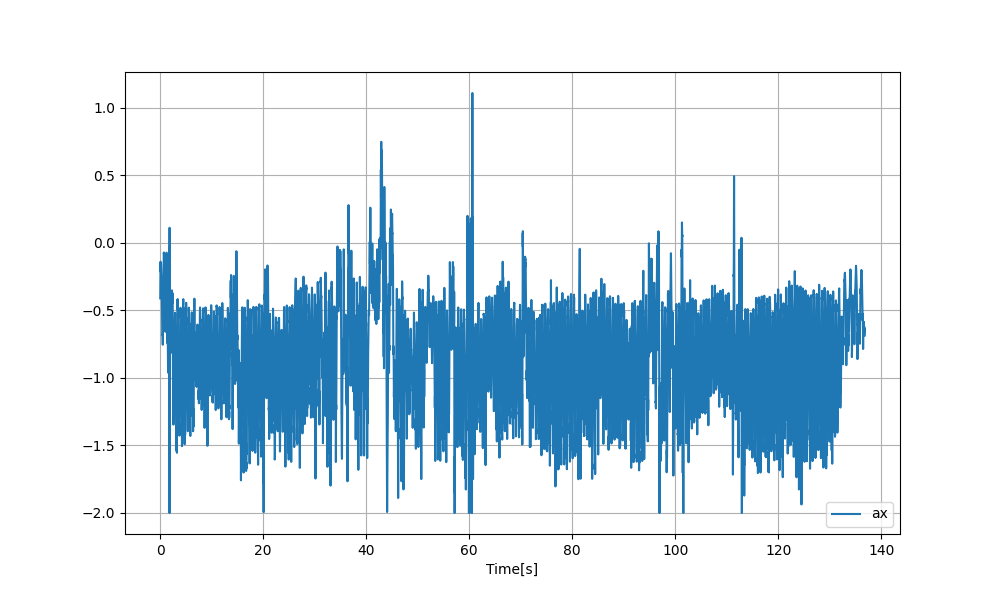

In [5]:
# Display a simple plot
trace.plot(['ax'])

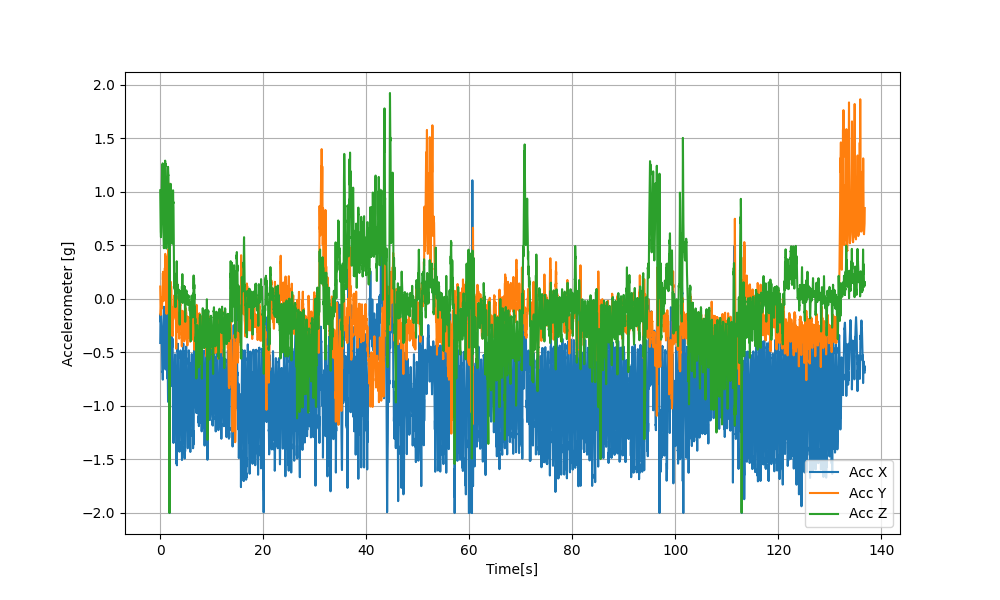

In [6]:
# Plot multiple axis at the same time
# It's also possible to give titles to the y-axis and plots
trace.plot(['ax', 'ay', 'az'], ylabels=['Accelerometer [g]'], labels=['Acc X', 'Acc Y', 'Acc Z'])

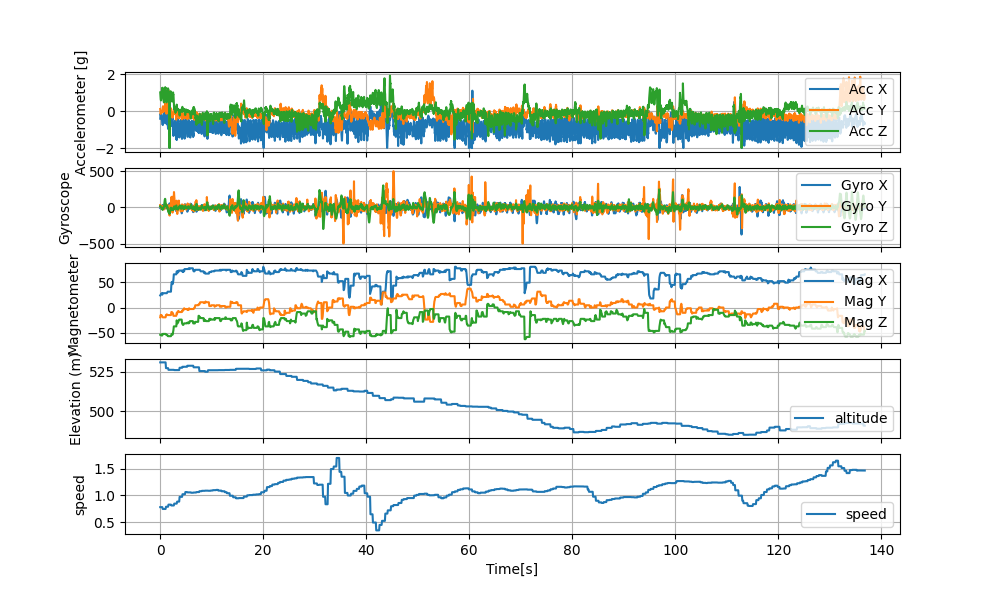

In [7]:
# Plot multiple sensors and multiple axis at the same time
trace.plot([['ax', 'ay', 'az'], ['gx', 'gy', 'gz'], ['mx', 'my', 'mz'], ['altitude'], ['speed']], 
             ylabels=['Accelerometer [g]', 'Gyroscope', 'Magnetometer', 'Elevation (m)', 'speed'],
             labels=[['Acc X', 'Acc Y', 'Acc Z'], ['Gyro X', 'Gyro Y', 'Gyro Z'], ['Mag X', 'Mag Y', 'Mag Z'], ['altitude'], ['speed']])

# Display GPS data

In [13]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, AntPath, Marker, Icon

# trace must contain gps data
assert('latitude' in trace.data and 'longitude' in trace.data)

coords = list(zip(trace.data['latitude'].values, trace.data['longitude'].values))
m = Map(center=coords[int(len(coords)/2)], max_zoom=22, zoom=18, basemap=basemaps.OpenStreetMap.Mapnik)
m.layout.width='900px'
m.layout.height='600px'
ant_path = AntPath(locations=coords, delay=2000)
m.add_layer(ant_path)
 
# display directional speed if data available
if 'speed' in trace.data:
    for i in range(len(coords)):
        if i % 20 == 0:
            size = trace.data['speed'].values[i] * 20
            middle = int(size/2)
            icon = Icon(icon_url='img/arrow.png', icon_size=[size, size])
            marker = Marker(location=coords[i], draggable=False, rotation_angle=trace.data['bearing'].values[i]-90, rotation_origin='middle center', icon=icon)
            m.add_layer(marker)

m

Map(center=[47.3776006, 8.5484207], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

# Generate computed traces

Small example that adds an accelerometer magnitude trace

<code>Dataset.fromLists(name, values, timestamps)</code> can be used to save a new or modified sensor into the Recording object.

<code>name</code>: used for plotting  
<code>values</code>: modified values  
<code>timestamps</code>: list of timestamps, one timestamp per value, usually directly taken from the original data

Note: This change is only executed locally and not saved to the json file. Everytime you reload your dataset, you have to re-execute this calculation


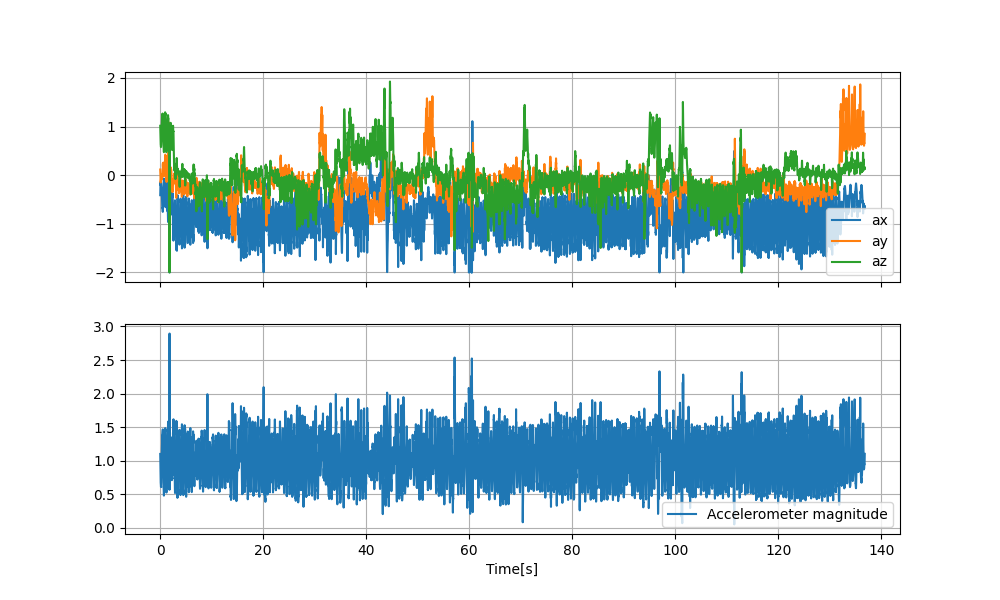

In [14]:
from math import sqrt
# trace must contain lilygo accelerometer data
assert('ax' in trace.data and 'ay' in trace.data and 'az' in trace.data)
# and those traces must be of the same length
assert(len(trace.data['ax'].values) == len(trace.data['ay'].values)  and len(trace.data['ax'].values) == len(trace.data['az'].values) )

magn = [sqrt(a**2+trace.data['ay'].values[i]**2+trace.data['az'].values[i]**2)for i, a in enumerate(trace.data['ax'].values)]

trace.data['amagn'] = Dataset.fromLists('Accelerometer magnitude', magn, trace.data['ax'].timestamps)

trace.plot([['ax', 'ay', 'az'], ['amagn']])

# FYI: How timestamps are handeled (you probably don't need this)

Every time the app receives a bluetooth package, up to 16 sensor values are stored at once together with the current timestamp. So not every sensor reading has a 100% perfectly defined timestamp.

Every <code>Dataset</code> has a list of <code>raw_timestamps</code> which are tuples of type <code>(packet number, timestamp)</code>

The timestamps are standard unix timestamps in milliseconds

For example the first two entries say "The 0th value came in at 1641564932653, the 16th value at 1641564932694"

In [9]:
trace.data['ax'].raw_timestamps[-1][1]-trace.data['ax'].raw_timestamps[0][1]

136789

The LILYGO uses a FIFO with a constant sample rate, so it should be a fair assumption, that the delay between two consecutive reaings always is the same.

By default the <code>Dataset.timestamps</code> list is linearly interpolated between the first and the last timestamps (<code>linspace(0, last_timestamp, num=len(values))</code>)

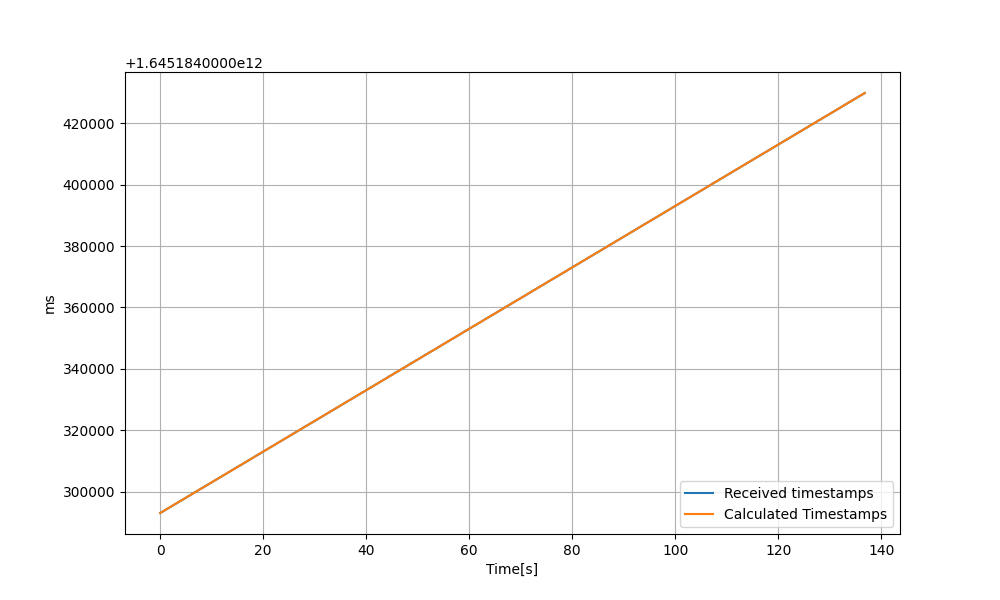

In [15]:
# Compare "ideal" interpolated timestamps against actual received timestamps
trace.data['ideal_ts'] = Dataset('ideal_ts', 
                                   [trace.data['timestamp'].values[0],trace.data['timestamp'].values[-1]], 
                                   [(0,trace.data['timestamp'].values[0]), 
                                    (len(trace.data['timestamp'].values), trace.data['timestamp'].values[-1])])
trace.plot(['timestamp', 'ideal_ts'], labels=['Received timestamps', 'Calculated Timestamps'], ylabels=['ms'])